In [13]:
using Plots
using SpecialFunctions
using Unitful, UnitfulAtomic
using HDF5, CSV, DataFrames
using LegendHDF5IO
using SolidStateDetectors
using ImageFiltering, Noise, DSP, RadiationDetectorSignals
using Random, Distributions,StatsBase, LinearAlgebra
using GePixDet

## Read data with fields and geant4 simulations
We suppose: 

    -- you have previously computed the fields with SSD. Here file: 
    LEAPS_INNOV_mirion_size_big_pixel_interpixel_400um_impurity_03_HV_200V_1pc_batch.h5
    
    -- you have previously simulated the interactions of photons with Geant4 for a given case
    
    -- you have some baselines from your detector (otherwise just introduce some random noise)

###  1) Transfer function  
Here we just assume a gaussian transfer function but the idea is that it can be measured

In [5]:
d = Normal(0,6)
x = rand(d, 10^6)
h = fit(Histogram, x, -20.5:1.0:20.5)
h_n=normalize(h, mode=:pdf)
transfer_function = vcat(zeros(1),h_n.weights[1:end]);

### 2) Geant4 simulations
For this example we will use simulations of EviroMAT sample with LEAPS-INNOV BP

In [10]:
base_dir = "/lustre/work/experiences/detecteurs/manzanillas/LEAPS_INNOV/Real_case_leaps/Geant4_output/gamma_32_keV_x_source_0mm_GeThickness_4mm_setup_3_collimator_tungsten_alloy_3mm/"
files = filter(x->occursin("LEAPS_INNOV_leaps_BP_enviroMAT_z_50mm_pol_90d_99pc_run_160",x), readdir(base_dir))
Rec_files = base_dir.*files
datos =Vector{}(undef,length(Rec_files))
for i=1:1:length(Rec_files)
        datos[i] = CSV.read(Rec_files[i],DataFrame, header=[:evt, :x, :y, :z, :E],skipto=10)
end
df_g4_BP = vcat(datos...)

14441×5 DataFrame
   Row │ evt        x         y          z        E          
       │ Int64      Float64   Float64    Float64  Float64    
───────┼─────────────────────────────────────────────────────
     1 │     24264  -5.01842   2.88842   2.04      1222.8
     2 │     24264  -5.03525   2.88957   2.00349   1222.8
     3 │     24264  -5.03749   2.88437   1.99432     81.9095
     4 │     24264  -5.03747   2.88435   1.99435   8539.49
     5 │     24264  -5.02174   2.89009   1.99802    860.334
     6 │     24264  -5.02154   2.89014   1.9981   18255.2
     7 │    140791   3.76903  -0.848687  2.04      1255.4
     8 │    140791   3.77029  -0.849335  2.01045    188.378
     9 │    140791   3.77031  -0.849339  2.01046   4906.07
    10 │    289098   1.19456   1.30781   2.04       124.98
    11 │    289098   1.19457   1.30786   2.03743    261.417
   ⋮   │     ⋮         ⋮          ⋮         ⋮         ⋮
 14432 │ 199891109   3.327    -1.72869   2.02128   2986.41
 14433 │ 199959727  -3.43003  -2.78338   2.04       129.4
 14434 │ 199959727  -3.43652  -2.78749   1.93625   1255.4
 14435 │ 199959727  -3.43641  -2.7884    1.93628    305.158
 14436 │ 199959727  -3.43646  -2.78845   1.93629   9377.04
 14437 │ 199959727  -3.43652  -2.78749   1.93625    571.745
 14438 │ 199959727  -3.43666  -2.78763   1.93615  18490.4
 14439 │ 199964247   5.8595    3.04604   2.04      1402.3
 14440 │ 199964247   5.86034   3.04656   2.02825    234.191
 14441 │ 199964247   5.86034   3.04659   2.02824   5378.87
                                           14420 rows omitted

### 3) Fields 
Here we read the fields reviously calculated with SSD 

In [4]:
ssd_sim_result=ssd_read("/lustre/work/experiences/detecteurs/manzanillas/SSD/LEAPS_INNOV_mirion_size_big_pixel_interpixel_400um_impurity_03_HV_200V_1pc_batch.h5", Simulation)

Simulation{Float32, Cartesian} - Coordinate system: Cartesian
  Environment Material: Vacuum
  Detector: LEAPS big pixel
  Electric potential: 

(880, 846, 296)
  Charge density: (880, 846, 296)
  Impurity scale: (880, 846, 296)
  Fix Charge density: (880, 846, 296)
  Dielectric distribution: (881, 847, 297)
  Point types: (880, 846, 296)
  Electric field: (880, 846, 296)
  Weighting potentials: 
    Contact 1: (1028, 934, 300)
    Contact 2: (532, 652, 272)
    Contact 3: (706, 592, 268)
    Contact 4: (690, 748, 272)
    Contact 5: (676, 752, 268)
    Contact 6: (668, 578, 268)
    Contact 7: (678, 754, 268)
    Contact 8: (690, 752, 272)
    Contact 9: (730, 1180, 234)
    Contact 10: (794, 600, 230)
    Contact 11: (736, 1204, 234)
    Contact 12: (1234, 1738, 292)


### 4) Electronic noise 
Here we read baseline data that was taken from SAMBA detector to introduce electronic noise

These should be replaced with baseline data from the detectors of LEAPS-INNOV (if you want to study those detectors)

In [6]:
baselines = h5read("/lustre/work/experiences/detecteurs/manzanillas/samba/Real_baseline.hdf5", "baselines")

37621×2000 Matrix{Float64}:
    3.53614    117.604     -24.9807   …    60.5698     32.053       32.053
   99.4668      13.9163     99.4668       -71.6343    -14.6006      13.9163
    8.44104      8.44104    65.4747       122.508       8.44104    -48.5926
  -29.0872     -29.0872    142.014       -143.155     -86.1208     -57.604
  119.029      -23.5549     90.5125       119.029      33.4788       4.96195
  -53.3265      32.2241      3.70722  …    32.2241      3.70722      3.70722
   27.2051     -29.8286    -29.8286       112.756      55.7219     -29.8286
   11.9201      68.9537    -16.5968        11.9201     68.9537     -16.5968
  -14.0302    -128.098    -128.098         14.4866     43.0034     -71.0639
   90.9687      62.4519    119.486         62.4519   -108.649       90.9687
   10.9505      67.9842    125.018    …   -74.6        10.9505      67.9842
   61.6534      61.6534     61.6534       147.204      61.6534      33.1366
   -0.684419   141.9        56.3493        27.8324     -0.68

# Analysis using all the ingredients
Here we will use all the ingredients to describe step by step the simulation process 

### 1) Get the index of the events in the Geant4 
Here we use the function get_evts_index(g4_file_dat_frame) to get the index of the events. So we can give the info to SSD with hits positions + energy 

In [80]:
Index_evts = get_evts_index(df_g4_BP)

2709×3 Matrix{Int64}:
    1      1      6
    2      7      9
    3     10     12
    4     13     17
    5     18     23
    6     24     29
    7     30     32
    8     33     39
    9     40     44
   10     45     47
   11     48     52
   12     53     58
   13     59     63
    ⋮         
 2698  14363  14370
 2699  14371  14377
 2700  14378  14385
 2701  14386  14390
 2702  14391  14395
 2703  14396  14400
 2704  14401  14403
 2705  14404  14406
 2706  14407  14421
 2707  14422  14424
 2708  14425  14432
 2709  14433  14438

### 2) Generate waveforms
Here we just use the first 2 events to illustrate the process. First without noise and then we will introduce a dt between the events and noise

In [81]:
example_evt = 3
start_evt = Index_evts[example_evt,2]
finish_evt = Index_evts[example_evt,3]
wf_evt1, E_true_evt1 = get_wfs_evt(ssd_sim_result,df_g4_BP[start_evt:finish_evt,:]);

example_evt = 4
start_evt = Index_evts[example_evt,2]
finish_evt = Index_evts[example_evt,3]
wf_evt2, E_true_evt2 = get_wfs_evt(ssd_sim_result,df_g4_BP[start_evt:finish_evt,:]);

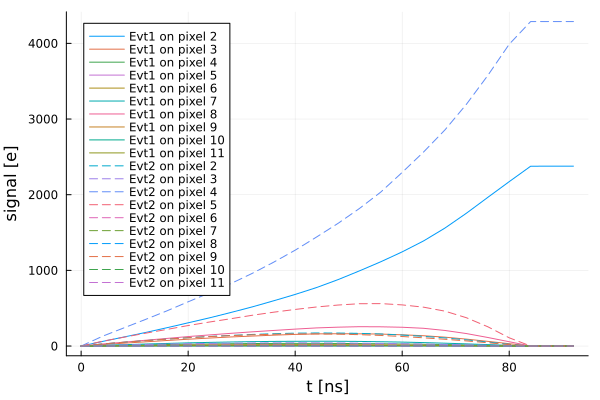

In [82]:
plot(wf_evt1,label="Evt1 on pixel ".*string.((2:11)'))
plot!(wf_evt2,ls=:dash,label="Evt2 on pixel ".*string.((2:11)'))

In [83]:
#A random dt between the events
shift =  rand(Poisson(80),1)[1] + length(wf_evt1[1].signal)

100

In [84]:
#Add pile up
pu_wfs = add_PileUp.(wf_evt1,wf_evt2,shift);

In [85]:
#Add baseline and amplification
wfs_with_tail = add_baseline_and_extend_tail.(pu_wfs,250,1000)
wfs_with_tail_amp = add_amplification.(wfs_with_tail,tuple(transfer_function));

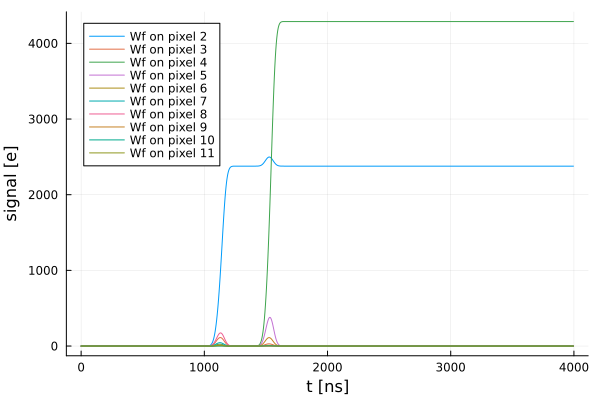

In [86]:
#Plot to verify that it worked as expected
plot(wfs_with_tail_amp,label="Wf on pixel ".*string.((2:11)'))

In [87]:
#Add electronics noise
ro_pixels = 10
base_ids = rand(1:length(baselines[:,1]),ro_pixels)
y_noise = []
for i in base_ids
    push!(y_noise,baselines[i,:]) 
end
wfs_with_tail_amp_noise = add_electronics_noise.(wfs_with_tail_amp,y_noise);

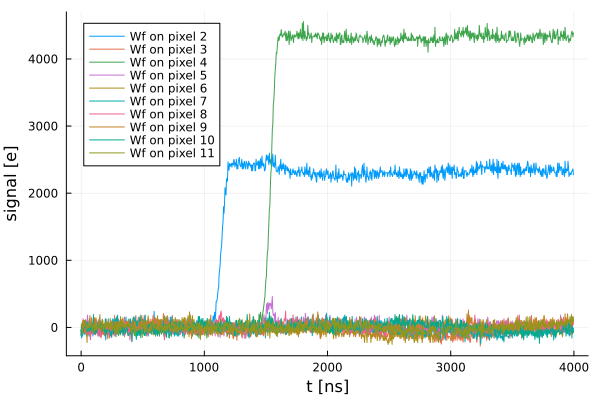

In [88]:
#Plot to verify that worked as expected
plot(wfs_with_tail_amp_noise,label="Wf on pixel ".*string.((2:11)'))

### 3) Energy reconstruction 

In [89]:
#Apply a trapezoidal filter to all waveforms
pixel_trap = trap_norm.(wfs_with_tail_amp_noise,150,10,true);

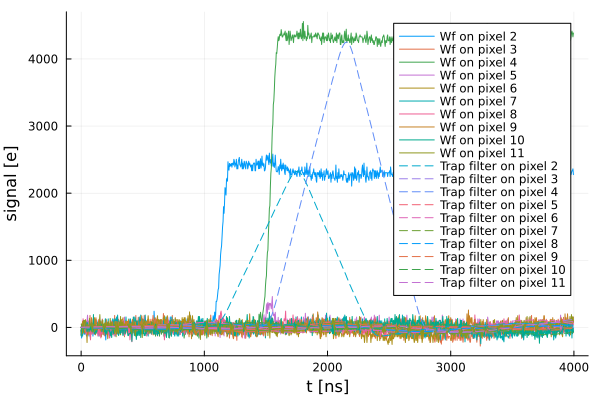

In [90]:
plot(wfs_with_tail_amp_noise,label="Wf on pixel ".*string.((2:11)'),legend=:topright)
plot!(wfs_with_tail_amp_noise[1].time,pixel_trap,ls=:dash,label="Trap filter on pixel ".*string.((2:11)'))

In [91]:
#Find peaks in waveform using minimum value of 350 e (~1 keV)
evts_in_wf = find_peaks.(pixel_trap;minpeakheight=350,minpeakdistance=10,threshold=50)

10-element Vector{Vector{NamedTuple{(:value, :idx, :start, :stop), Tuple{Float64, Int64, Int64, Int64}}}}:
 [(value = 2324.1281274477187, idx = 440, start = 264, stop = 609)]
 []
 [(value = 4249.883231159139, idx = 539, start = 357, stop = 710)]
 []
 []
 []
 []
 []
 []
 []

In [92]:
##Access the information
for i = 1:length(evts_in_wf)
    if length(evts_in_wf[i]) == 0
        continue
    else
        amplitude = getproperty.(evts_in_wf[i], :value)
        position = getproperty.(evts_in_wf[i], :idx)
        pixel_id = repeat([i], length(amplitude))
        println("Evt on pixel $(i) with amplitude $(amplitude[1])")
    end
end

Evt on pixel 1 with amplitude 2324.1281274477187
Evt on pixel 3 with amplitude 4249.883231159139


### Put all in a function 
Here we just put all the steps described before in a single function to process the geant4 file

In [93]:
function get_values_pu(ssd_info,df::DataFrame,n_pile_ups::Int)
    Index_evts = get_evts_index(df)
    time_evt = []
    pixel_charge = []
    total_energy = []
    pixels_ID = []
    section_ID = []
    wf_evt = []
    ro_pixels = 10
    section = 0
    #println("last evt: ",Index_evts[end,1])
    #wf_debug = []
    for evt_counter = 1 : n_pile_ups :  Index_evts[end,1] - n_pile_ups + 1
        wfs_all = []
        E_true_evts = zeros(n_pile_ups)
        section += 1
        second_counter = evt_counter 
        #get waveforms of all events
        for first_evt = 1 : 1 : n_pile_ups
            start_evt = Index_evts[second_counter,2]
            finish_evt = Index_evts[second_counter,3]
            #println("evt counter: ",evt_counter," second counter: ",second_counter," start: ",start_evt," ends: ",finish_evt)
            wf_evt, E_true_evts[first_evt] = get_wfs_evt(ssd_info,df[start_evt:finish_evt,:],4u"ns",1)
            second_counter += 1
            push!(wfs_all,wf_evt)
            
        end
        pu_wfs = wfs_all[1]
        shift =  rand(Poisson(80),1)[1] + length(pu_wfs[1].signal)  
        for n_evt = 2 : 1 : n_pile_ups
            pu_wfs_test = wfs_all[n_evt]
            pu_wfs = add_PileUp.(pu_wfs,wfs_all[n_evt],shift)
            shift = length(pu_wfs[1].signal) + rand(Poisson(80),1)[1]
        end
        #Add tail and baseline
        wfs_with_tail = add_baseline_and_extend_tail.(pu_wfs,250,1000)
        wfs_with_tail_amp = add_amplification.(wfs_with_tail,tuple(transfer_function))
        #Add electronics noise
        base_ids = rand(1:length(baselines[:,1]),ro_pixels)
        y_noise = []
        for i in base_ids
            push!(y_noise,baselines[i,:]) 
        end
        wfs_with_tail_amp_noise = add_electronics_noise.(wfs_with_tail_amp,y_noise)
        #Get energies
        pixel_trap = trap_norm.(wfs_with_tail_amp_noise,125,10,true)
        evts_in_wf = find_peaks.(pixel_trap;minpeakheight=350,minpeakdistance=10,threshold=50)
        amplitudes = []
        positions = []
        pixel_ids = []
        for i = 1:length(evts_in_wf)
            if length(evts_in_wf[i]) == 0
                continue
            else
                amplitude = getproperty.(evts_in_wf[i], :value)
                position = getproperty.(evts_in_wf[i], :idx)
                pixel_id = repeat([i], length(amplitude))
                push!(amplitudes,amplitude)
                push!(positions,position)
                push!(pixel_ids,pixel_id)
            end
        end
        pixel_energies = vcat(amplitudes...)
        pixel_sections = fill(section, length(pixel_energies))
        t_evt = vcat(positions...)
        id_pixels = vcat(pixel_ids...)
        #wf_debug = pixel_trap
        ##end pile up
        if length(pixel_energies) > 0
            push!(time_evt,t_evt)
            push!(pixel_charge,pixel_energies)
            push!(pixels_ID,id_pixels)
            push!(total_energy,E_true_evts)
            push!(section_ID,pixel_sections)
        end
    end
    #return wf_debug
    return data_to_save = [total_energy pixel_charge time_evt pixels_ID section_ID]
end

get_values_pu (generic function with 1 method)

In [94]:
data_to_save = get_values_pu(ssd_sim_result,df_g4_BP,3)

902×5 Matrix{Vector}:
 [30182.5, 6349.85, 7016.95]  …  [1, 3, 6]   [1, 1, 1]
 [12656.3, 29664.2, 15737.2]     [3, 6, 7]   [2, 2, 2]
 [6349.85, 29088.2, 25257.2]     [1, 5, 6]   [3, 3, 3]
 [6362.71, 25257.2, 29062.3]     [1, 1, 2]   [4, 4, 4]
 [25052.8, 30629.4, 7016.95]     [3, 5, 6]   [5, 5, 5]
 [6349.85, 15737.2, 14124.6]  …  [3, 4]      [6, 6]
 [6362.71, 6362.71, 8005.71]     [3]         [7]
 [15649.8, 6362.71, 6349.85]     [1, 2, 5]   [8, 8, 8]
 [25023.2, 27895.0, 15091.0]     [3, 4]      [9, 9]
 [13353.9, 6362.71, 15649.8]     [2, 4]      [10, 10]
 [27436.9, 15310.1, 25257.2]  …  [4, 6]      [11, 11]
 [25257.2, 6362.71, 15737.2]     [2, 3, 6]   [12, 12, 12]
 [26752.0, 4280.4, 22957.1]      [2, 3, 6]   [13, 13, 13]
 ⋮                            ⋱              
 [5925.6, 25023.2, 30067.1]   …  [3, 5]      [892, 892]
 [6349.85, 16695.7, 29088.2]     [2, 3, 4]   [893, 893, 893]
 [6362.71, 25257.2, 25257.2]     [1, 2, 3]   [894, 894, 894]
 [7016.95, 29498.5, 29708.0]     [2, 6, 10]  [8

In [97]:
A_E_ADC = vcat(data_to_save[:,2]...)
A_evts_time = vcat(data_to_save[:,3]...)
A_evts_pixels = vcat(data_to_save[:,4]...)
A_E_true = vcat(data_to_save[:,1]...)
A_ID = vcat(data_to_save[:,5]...)

2375-element Vector{Int64}:
   1
   1
   1
   2
   2
   2
   3
   3
   3
   4
   4
   4
   5
   ⋮
 898
 899
 899
 900
 900
 901
 901
 902
 902
 903
 903
 903

In [98]:
h5open("./testing_3_E_32keV_pt_125_file_1.h5", "w") do file
    write(file, "A_E_ADC", A_E_ADC)
    write(file, "A_E_true", A_E_true)
    write(file, "A_evts_time", A_evts_time)
    write(file, "A_evts_pixels", A_evts_pixels)
end

In [111]:
h_E_rec = fit(Histogram, A_E_ADC,1:20:34*360)

Histogram{Int64, 1, Tuple{StepRange{Int64, Int64}}}
edges:
  1:20:12221
weights: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
closed: left
isdensity: false

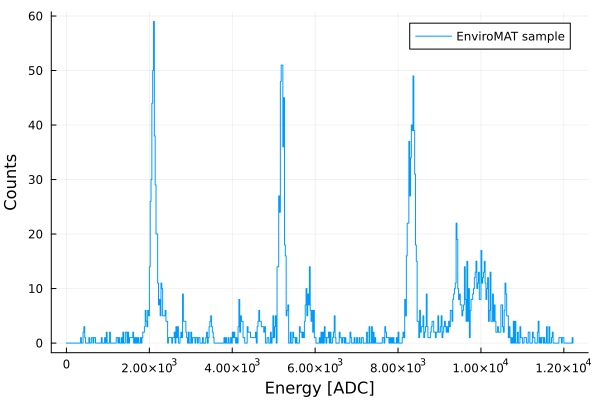

In [112]:
plot(h_E_rec,st=:step,label="EnviroMAT sample",xlabel="Energy [ADC]",ylabel="Counts")